In [48]:
import sys,os,os.path

sys.path.append("../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio


In [50]:
# list of all files in a folder
folder_path = 'isaura'
file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

dfs = []
# create massive dataframe with all of them
for file in file_names:
    file_path = 'isaura/' + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)

tracks = pd.concat(dfs, axis=0, ignore_index=True)



##### Loading file

Lets try and load the magical file in, usually I'd use h5py but not here because IC doesn't.

The different outputs can be read about [here](https://next-exp-sw.readthedocs.io/en/latest/isaura.html).



In [81]:
#tracks = dstio.load_dst(file, 'Tracking', 'Tracks')
#evts = dstio.load_dst(file, 'Summary', 'Events')
#pen_out = dstio.load_dst(file, 'DST', 'Events')
#hit_flag = dstio.load_dst(file, 'Filters', 'hits_select')
#top_flag = dstio.load_dst(file, 'Filters', 'topology_select')
print(len(tracks))

49646


In [52]:
tracks.head()

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.94982
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.94982
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.31097
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.96313
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.96313


In [53]:
evts.head()

,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map
0,360000,1.581900,-1.0,1,6221,257.790644,195.855253,904.025533,323.784509,244.675,183.675,889.993965,309.545007,268.675,214.675,916.808865,337.149464,False
1,360002,1.589988,-1.0,1,6702,312.172050,-230.269360,738.927878,387.995994,281.675,-257.325,723.679950,340.779271,335.675,-187.325,751.342410,418.752745,False
2,360004,0.562250,-1.0,4,5906,-179.414087,154.770940,514.825292,260.340484,-242.325,86.675,409.527405,217.744486,50.675,483.675,532.089232,485.553974,False
3,360006,1.534473,-1.0,3,6384,-266.496462,273.303794,287.190055,381.791106,-279.325,248.675,265.866851,357.826929,-221.325,320.675,311.154952,410.530098,False
4,360008,1.685625,-1.0,4,6698,317.066718,79.755581,1136.305261,326.976779,272.675,38.675,1120.142835,281.685305,334.675,93.675,1166.995200,342.618682,False


In [54]:
pen_out.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,360000,3.600003e+11,0,0,1,1,600.0,201.0,743.0,10000.0,...,64,1075.487671,903.409607,6.499579,258.252300,196.371343,324.431741,0.650115,19.388149,19.619248
1,360002,3.600023e+11,0,0,1,1,500.0,175.0,679.0,10000.0,...,76,885.487976,743.809875,7.801953,310.405620,-227.931953,385.103394,-0.633379,24.079286,26.884608
2,360004,3.600047e+11,0,0,1,3,525.0,159.0,481.0,10000.0,...,26,496.483795,417.046387,7.388782,34.773073,477.965376,479.228617,1.498172,16.417060,11.972731
3,360004,3.600047e+11,0,1,1,3,525.0,159.0,481.0,10000.0,...,31,626.480408,526.243530,3.514959,-203.017289,118.407661,235.024241,2.613588,15.812903,15.707273
4,360004,3.600047e+11,0,2,1,3,525.0,159.0,481.0,10000.0,...,5,668.489868,561.531433,3.460819,-234.834507,114.052021,261.065335,2.689475,7.611830,10.073714


In [55]:
hit_flag.head()

,event,passed
0,360000,True
1,360002,True
2,360004,True
3,360006,True
4,360008,True


In [56]:
top_flag.head()

,event,passed
0,360000,True
1,360002,True
2,360004,True
3,360006,True
4,360008,True


##### So I'm pretty sure we care about the tracks rather than the rest of the stuff, lets look at it and compare to beersheba.

In [57]:
tracks.head(20)
# so you can see here that the events with one track are
# 360000, 360002, 360012, etc

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.949820
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.949820
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.310970
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.963130
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.963130
5,4,2,0.004177,0.000000,1,34,4,-320.325,-24.325,282.624510,...,283.651955,-318.304511,-22.985617,283.651955,0.004177,0.004177,0.004177,10.000000,9.857143,4.963130
6,4,3,0.000652,0.000000,1,8,4,-357.325,-69.325,275.932729,...,275.932729,-356.181234,-68.195886,275.932729,0.000652,0.000652,0.000652,10.000000,9.857143,4.963130
7,6,0,1.466383,58.545117,64,5961,1,216.675,178.675,508.637902,...,511.999816,229.008420,201.182692,553.531317,0.695194,0.581122,0.000000,8.250000,9.666667,4.781579
8,8,0,1.221341,55.711321,51,6037,4,270.675,302.675,382.657144,...,413.722566,276.613873,331.771804,385.444785,0.656785,0.301739,0.000000,9.827586,10.000000,4.979070
9,8,1,0.164885,14.878595,5,1187,4,33.675,-55.325,721.989870,...,724.454160,36.315776,-42.971393,728.701016,0.164885,0.164875,0.164875,9.827586,10.000000,4.979070


In [58]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 4


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.0,9.857143,4.96313
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.0,9.857143,4.96313
5,4,2,0.004177,0.000000,1,34,4,-320.325,-24.325,282.624510,...,283.651955,-318.304511,-22.985617,283.651955,0.004177,0.004177,0.004177,10.0,9.857143,4.96313
6,4,3,0.000652,0.000000,1,8,4,-357.325,-69.325,275.932729,...,275.932729,-356.181234,-68.195886,275.932729,0.000652,0.000652,0.000652,10.0,9.857143,4.96313


In [59]:
# look at all the columns
col_titles = tracks.columns.tolist()
clean_output = "\n".join(col_titles)
print(clean_output)

event
trackID
energy
length
numb_of_voxels
numb_of_hits
numb_of_tracks
x_min
y_min
z_min
r_min
x_max
y_max
z_max
r_max
x_ave
y_ave
z_ave
r_ave
extreme1_x
extreme1_y
extreme1_z
extreme2_x
extreme2_y
extreme2_z
blob1_x
blob1_y
blob1_z
blob2_x
blob2_y
blob2_z
eblob1
eblob2
ovlp_blob_energy
vox_size_x
vox_size_y
vox_size_z


##### Cuts

We want to:
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV

In [60]:
def cut_effic(df1, df2):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    return efficiency


In [61]:
def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (keV)'):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    # control viewing of hist
    if (fill == True):
        plt.hist(energy_vals, bins = binning, label = label)
    else:
        plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    else:
        return

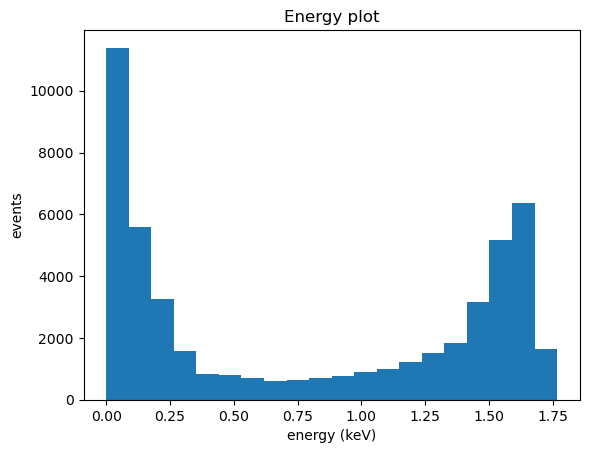

In [62]:
# plot the energy
plot_hist(tracks)

In [63]:
# testing gth_lth_cuts logic
display(tracks.head())
# we'll remove event 360004 trackID 1 by applying cut < 22mm for xmin
display((tracks[(abs(tracks['x_min']) >= 22)]).head())
print("Are arrays the same length with this cut applied?")
print(len((tracks[(abs(tracks['x_min']) >= 22)])) == len(tracks))
print("How about with a 0 cut?")
print(len((tracks[(abs(tracks['x_min']) >= 0)])) == len(tracks))
print("Checks out")

# but we care about radius, need to check if radius is ever negative.
print((tracks['r_max'] <= 0))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.94982
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.94982
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.31097
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.96313
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.96313


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.94982
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.94982
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.31097
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.96313
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.96313


Are arrays the same length with this cut applied?
False
How about with a 0 cut?
True
Checks out
0        False
1        False
2        False
3        False
4        False
         ...  
49641    False
49642    False
49643    False
49644    False
49645    False
Name: r_max, Length: 49646, dtype: bool


In [64]:
'''def gth_lth_cuts(df, column_title, one_sided = False, lower_lim = 0, upper_lim = 0, absolute = True):
    #applies cut on column via upper and lower limits (greater than, lesser than)
    #column title for two sided should be a tuple!

    # double sided
    if (one_sided==False):
        # conditional absolute for fiducial case, so include negative values within this range.
        if (absolute == True):
            filt_df = df[(abs(df[column_title[0]]) >= lower_lim) & (abs(df[column_title[1]]) <= upper_lim)]
        else:
            filt_df = df[(df[column_title[0]] >= lower_lim) & (df[column_title[1]] <= upper_lim)]
    # one sided (lower or upper limit)
    else:
        # set greater or lesser based on lower or upper limit being 0
        print("placeholder")
'''

def fiducial_track_cut(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Bespoke cutting algorithm for NEXT100 isaura which cuts for fiducial volume
    z is contrained in a two-sided fashion (greater and less than), while R is taken not treated is one-sided.
    '''

    # z filtering
    filt_z_df = df[(df['z_min'] >= lower_z) & (df['z_max'] <= upper_z)] # mm

    # r filtering
    filt_df = filt_z_df[(filt_z_df['r_max'] <= r_lim)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))

    return filt_df


In [65]:
def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events

In [66]:
def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove
    

In [67]:
def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df


##### Now lets look at the fiducial selection parameters to get a feeling of whats going on

In [68]:
def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

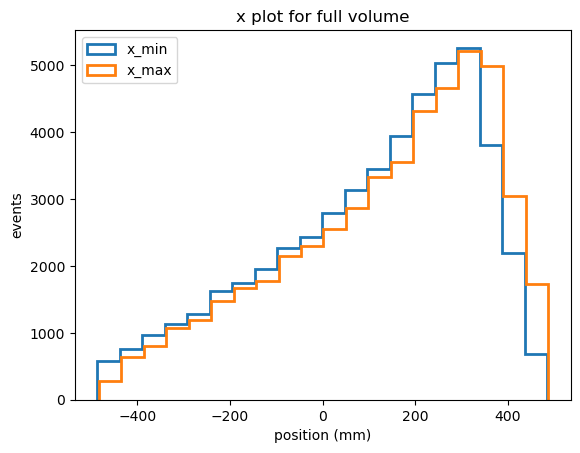

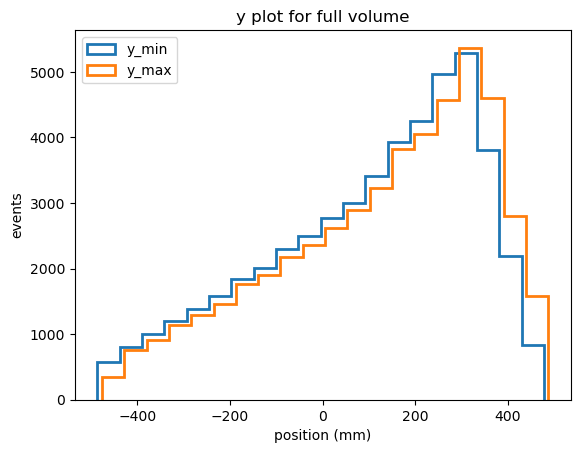

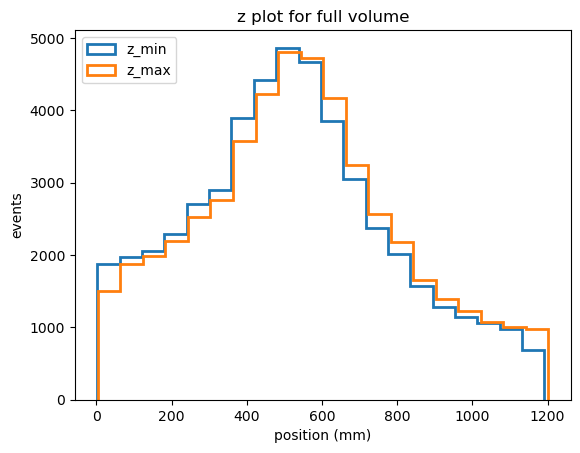

In [69]:
plot_volume_hists(tracks)

##### Considering the fiducial limits, this looks okay?
Limits:
- 20mmm < z < 1195mm
- r < 472mm (x and y limits in the -ve and negative)

Although the 472 radius seems really generous, maybe that cut has already been made? lets do a test


In [70]:
# checking what the largest x position is
x_max_max = tracks['x_max'].max()
print("Largest x_max values: {:.2f}".format(x_max_max))

Largest x_max values: 486.68


##### So this is outside the fiducial volume, this seems okay. Looking at when binning is changed from 20 -> 50, saw only artifacts in the z section.

##### So now to apply fiducial cuts

In [71]:
# for easy tracking
cut_names = []
rel_cut_effics = []
abs_cut_effics = []

cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial = fiducial_track_cut(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
ef = cut_effic(fiducial, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
abs_cut_effics.append(ef)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 88.58 %


##### And the one track cut

In [72]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial, verbose = True)
# absolute
one_track_abs = one_track_cuts(tracks)

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial)
rel_cut_effics.append(ef)

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_rel, tracks)
abs_cut_effics.append(ef)

Removing events with more than one track.
Events with one track: Int64Index([      0,       2,       6,      10,      12,      14,      16,
                 22,      28,      30,
            ...
            7960198, 7960212, 7960214, 7960216, 7960220, 7960224, 7960228,
            7960232, 7960238, 7960244],
           dtype='int64', name='event', length=12933)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.949820
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.310970
7,6,0,1.466383,58.545117,64,5961,1,216.675,178.675,508.637902,...,511.999816,229.008420,201.182692,553.531317,0.695194,0.581122,0.000000,8.250000,9.666667,4.781579
12,10,0,1.598264,90.017410,83,6868,1,304.675,70.675,558.203362,...,560.917601,312.928268,137.990505,605.108996,0.660614,0.463501,0.000000,10.000000,9.250000,4.575876
13,12,0,1.629635,128.330191,99,6883,1,167.675,326.675,559.875487,...,562.606480,238.081786,358.091384,639.517115,0.844407,0.176924,0.000000,9.111111,9.250000,4.839660


Single track cut
Relative Cut efficiency:
Efficiency: 55.17 %
Absolute Cut efficiency:
Efficiency: 48.88 %


#### Plot the spacial stuff and compare

Looks good to me

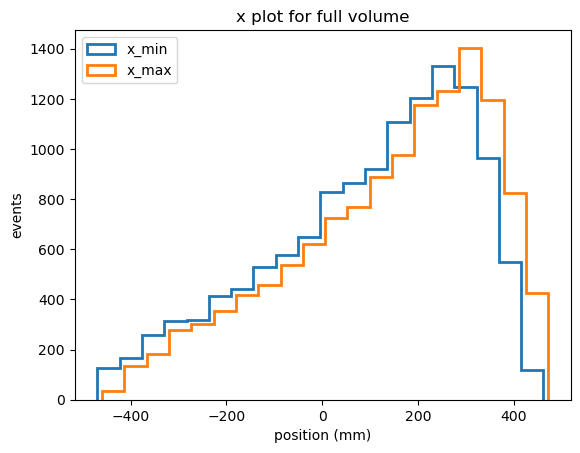

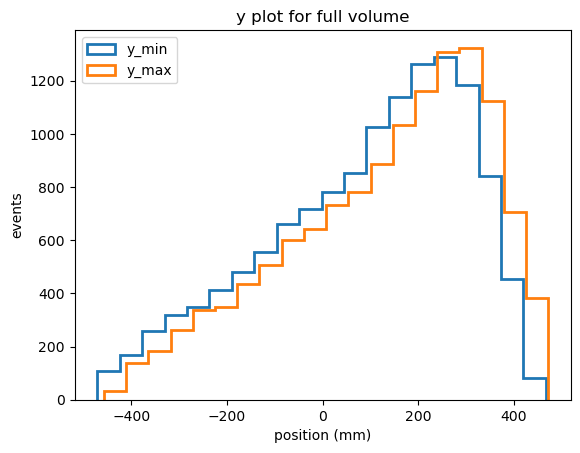

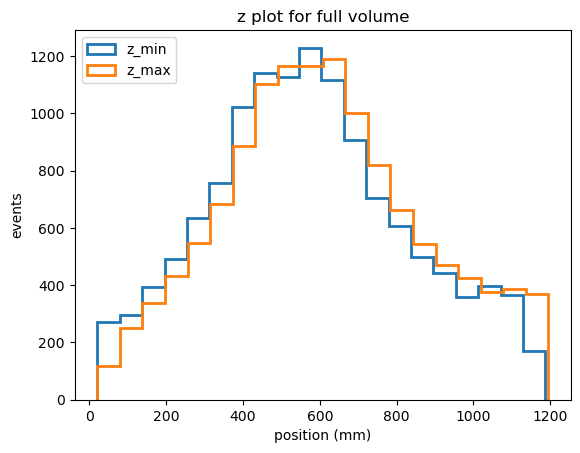

In [73]:
plot_volume_hists(one_track_rel)

#### No overlapping blobs

I have to assume this is achieved by setting ovlp_blob_energy, but lets look at these values and see if thats easy.

In [74]:
display(one_track_rel['ovlp_blob_energy'])


1        0.112234
2        0.000000
7        0.000000
12       0.000000
13       0.000000
           ...   
49622    0.000000
49634    0.000000
49638    0.000000
49640    0.123769
49645    0.000000
Name: ovlp_blob_energy, Length: 12933, dtype: float64

Seems to have a lot of values at zero, so I think this is an acceptable cut method

In [75]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

In [76]:
cut_names.append("Blob overlap cuts")


# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_rel, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.90 %
Absolute Cut efficiency:
Efficiency: 35.63 %


#### Energy cut

Want to limit range from [1.5, 1.7] MeV

In [77]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_rel, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 74.89 %
Absolute Cut efficiency:
Efficiency: 26.68 %


#### Print cut efficiency relative and absolute as a table and plot the energy of the final cuts

In [78]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'relative_efficiency': rel_cut_effics,
                             'absolute_efficiency': abs_cut_effics})

In [79]:
display(efficiencies)

,Cut,relative_efficiency,absolute_efficiency
0,Fiducial Cuts,88.583198,88.583198
1,One track cut,55.174915,48.875704
2,Blob overlap cuts,72.898786,35.629795
3,Energy cuts,74.893933,26.684555


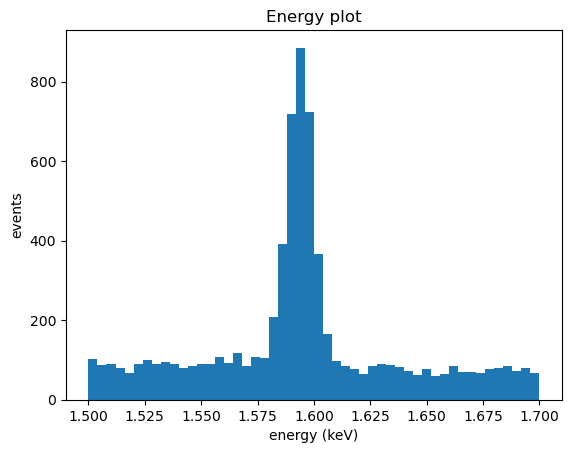

In [82]:
# plot energy of final
plot_hist(ecut_rel, binning = 50)

#### Histogram plotting showing the effect of all the cuts:

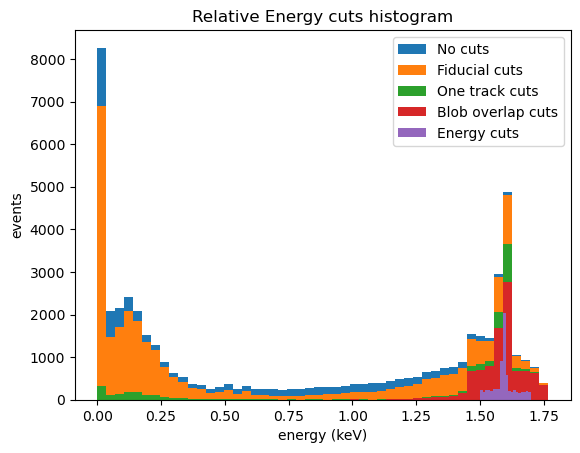

In [85]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title='Relative Energy cuts histogram')
plt.legend()
plt.show()

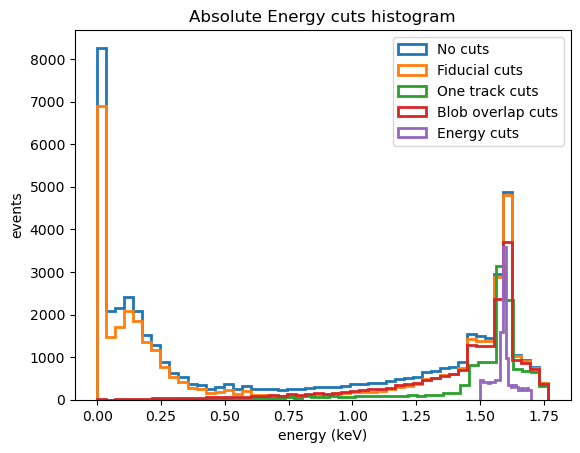

In [87]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Absolute Energy cuts histogram', fill = False)
plt.legend()
plt.show()